In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import pymc3 as pm

from pynba import blackontrans, plot_logos, team_id_to_team_abb
from pynba.load_parsed_data import load_games, estimate_shot_rate, estimate_attempt_rate, calc_scoring_rate


pd.set_option('display.float_format', lambda val: f'{val:.1f}')
pd.set_option('display.max_columns', 50)

In [2]:
DATA_PATH = "/home/jupyter/nba/notebooks/data/parsed_pbpstats"
LEAGUE = 'nba'
SEASON_TYPE = 'Regular Season'
YEAR = 2017

filters = [[('year', '=', YEAR), ('season_type', '=', SEASON_TYPE), ('league', '=', LEAGUE)]]
games = load_games(DATA_PATH, filters=filters)

In [3]:
def log5(mu, *args):
    mu0 = mu / (1 - mu)
    p0 = args[0] / (1 - args[0]) / mu0 ** (len(args) - 1)
    for arg in args[1:]:
        p0 *= arg / (1 - arg)
    return p0 / (p0 + 1)


class Inference:
    def __init__(self, games):
        self.games = games
        self.n_teams = self.games['off_team_id'].unique().shape[0]
        self.team_id_to_team_ind = {team_id: team_ind for team_ind, team_id in enumerate(self.games['off_team_id'].unique())}
        self.team_ind_to_team_id = {team_ind: team_id for team_id, team_ind in self.team_id_to_team_ind.items()}

        self.mu_three_make_rate = games['threes_made'].sum() / games['threes_attempted'].sum()
        self.mu_two_make_rate = games['twos_made'].sum() / games['twos_attempted'].sum()
        self.mu_three_attempt_rate = games['threes_attempted'].sum() / (games['twos_attempted'].sum() + games['threes_attempted'].sum())
        self.mu_ft_attempt_rate = games['ft_attempted'].sum() / games['possession_num'].sum()
        self.mu_ft_make_rate = games['ft_made'].sum() / games['ft_attempted'].sum()
        self.mu_off_reb_rate = games['off_rebs'].sum() / (games['off_rebs'].sum() + games['def_rebs'].sum())
        self.mu_turnover_rate = games['turnovers'].sum() / games['possession_num'].sum()
        self.mu_pace = games['duration'].sum() / games['possession_num'].sum()
    
        with pm.Model() as self.model:
            # Off rate priors
            off_three_make_rate = pm.Beta('off_three_make_rate', mu=self.mu_three_make_rate, sigma=0.02, shape=self.n_teams)
            off_two_make_rate = pm.Beta('off_two_make_rate', mu=self.mu_two_make_rate, sigma=0.02, shape=self.n_teams)
            off_three_attempt_rate = pm.Beta('off_three_attempt_rate', mu=self.mu_three_attempt_rate, sigma=0.05, shape=self.n_teams)
            off_off_reb_rate = pm.Beta('off_off_reb_rate', mu=self.mu_off_reb_rate, sigma=0.02, shape=self.n_teams)
            off_turnover_rate = pm.Beta('off_turnover_rate', mu=self.mu_turnover_rate, sigma=0.01, shape=self.n_teams)
            off_ft_attempt_rate = pm.Gamma('off_ft_attempt_rate', mu=self.mu_ft_attempt_rate, sigma=0.02, shape=self.n_teams)
            off_pace = pm.Gamma('off_pace', mu=self.mu_pace, sigma=0.5, shape=self.n_teams)
            off_ft_make_rate = pm.Beta('ft_make_rate', mu=self.mu_ft_make_rate, sigma=0.03, shape=self.n_teams)

            # Def rate priors
            def_three_make_rate = pm.Beta('def_three_make_rate', mu=self.mu_three_make_rate, sigma=0.01, shape=self.n_teams)
            def_two_make_rate = pm.Beta('def_two_make_rate', mu=self.mu_two_make_rate, sigma=0.02, shape=self.n_teams)
            def_three_attempt_rate = pm.Beta('def_three_attempt_rate', mu=self.mu_three_attempt_rate, sigma=0.02, shape=self.n_teams)
            def_off_reb_rate = pm.Beta('def_off_reb_rate', mu=self.mu_off_reb_rate, sigma=0.02, shape=self.n_teams)
            def_turnover_rate = pm.Beta('def_turnover_rate', mu=self.mu_turnover_rate, sigma=0.01, shape=self.n_teams)
            def_ft_attempt_rate = pm.Gamma('def_ft_attempt_rate', mu=self.mu_ft_attempt_rate, sigma=0.02, shape=self.n_teams)
            def_pace = pm.Gamma('def_pace', mu=self.mu_pace, sigma=0.25, shape=self.n_teams)

            # Home rate priors
            home_three_make_rate = pm.Beta('home_three_make_rate', mu=self.mu_three_make_rate + 0.0035, sigma=0.001)
            home_two_make_rate = pm.Beta('home_two_make_rate', mu=self.mu_two_make_rate + 0.0065, sigma=0.002)
            home_off_reb_rate = pm.Beta('home_off_reb_rate', mu=self.mu_off_reb_rate + 0.005, sigma=0.002)
            home_turnover_rate = pm.Beta('home_turnover_rate', mu=self.mu_turnover_rate - 0.0002, sigma=0.001)
            home_ft_attempt_rate = pm.Gamma('home_ft_attempt_rate', mu=self.mu_ft_attempt_rate + 0.005, sigma=0.002)
            home_ft_make_rate = pm.Gamma('home_ft_make_rate', mu=self.mu_ft_make_rate + 0.001, sigma=0.0005)

            # Implied away rate priors (assuming symmetry)
            away_three_make_rate = 2 * self.mu_three_make_rate - home_three_make_rate
            away_two_make_rate = 2 * self.mu_two_make_rate - home_two_make_rate
            away_off_reb_rate = 2 * self.mu_off_reb_rate - home_off_reb_rate
            away_turnover_rate = 2 * self.mu_turnover_rate - home_turnover_rate
            away_ft_attempt_rate = 2 * self.mu_ft_attempt_rate - home_ft_attempt_rate
            away_ft_make_rate = 2 * self.mu_ft_make_rate - home_ft_make_rate

            # Free throw attempt rate and pace distribution priors
            sigma_ft_attempt_rate = pm.Gamma('sigma_ft_attempt_rate', mu=0.05, sigma=0.01)
            sigma_pace = pm.Gamma('sigma_pace', mu=0.8, sigma=0.1)

            # Model rates for each game
            off_index = games['off_team_id'].map(self.team_id_to_team_ind).values
            def_index = games['def_team_id'].map(self.team_id_to_team_ind).values
            home_index = (games['off_team_id'] != games['home_team_id']).values.astype(int)
            games_three_make_rate = log5(
                self.mu_three_make_rate,
                off_three_make_rate[off_index],
                def_three_make_rate[def_index],
                pm.math.stack([home_three_make_rate, away_three_make_rate])[home_index]
            )
            games_two_make_rate = log5(
                self.mu_two_make_rate,
                off_two_make_rate[off_index],
                def_two_make_rate[def_index],
                pm.math.stack([home_two_make_rate, away_two_make_rate])[home_index]
            )
            games_three_attempt_rate = log5(
                self.mu_three_attempt_rate,
                off_three_attempt_rate[off_index],
                def_three_attempt_rate[def_index],
            )
            games_off_reb_rate = log5(
                self.mu_off_reb_rate,
                off_off_reb_rate[off_index],
                def_off_reb_rate[def_index],
                pm.math.stack([home_off_reb_rate, away_off_reb_rate])[home_index]
            )
            games_turnover_rate = log5(
                self.mu_turnover_rate,
                off_turnover_rate[off_index],
                def_turnover_rate[def_index],
                pm.math.stack([home_turnover_rate, away_turnover_rate])[home_index]
            )
            games_ft_attempt_rate = log5(
                self.mu_ft_attempt_rate,
                off_ft_attempt_rate[off_index],
                def_ft_attempt_rate[def_index],
                pm.math.stack([home_ft_attempt_rate, away_ft_attempt_rate])[home_index]
            )
            games_pace = log5(
                self.mu_pace,
                off_pace[off_index],
                def_pace[def_index],
            )
            games_ft_make_rate = log5(
                self.mu_ft_make_rate,
                off_ft_make_rate[off_index],
                pm.math.stack([home_ft_make_rate, away_ft_make_rate])[home_index]
            )

            # Fit model to observations
            pm.Binomial(
                'threes_made',
                n=games['threes_attempted'].values,
                p=games_three_make_rate,
                observed=games['threes_made'].values
            )
            pm.Binomial(
                'twos_made',
                n=games['twos_attempted'].values,
                p=games_two_make_rate,
                observed=games['twos_made'].values
            )
            pm.Binomial(
                'threes_attempted',
                n=games['twos_attempted'].values + games['threes_attempted'].values,
                p=games_three_attempt_rate,
                observed=games['threes_attempted'].values
            )
            pm.Binomial(
                'off_rebs',
                n=games['off_rebs'].values + games['def_rebs'].values,
                p=games_off_reb_rate,
                observed=games['off_rebs'].values
            )
            pm.Binomial(
                'turnovers',
                n=games['possession_num'].values,
                p=games_turnover_rate,
                observed=games['turnovers'].values
            )
            pm.Normal(
                'ft_attempt_rate',
                mu=games_ft_attempt_rate,
                sigma=sigma_ft_attempt_rate,
                observed=games['ft_attempt_rate'].values
            )
            pm.Gamma(
                'pace',
                mu=games_pace,
                sigma=sigma_pace,
                observed=games['pace'].values
            )
            pm.Binomial(
                'ft_made',
                n=games['ft_attempted'].values,
                p=games_ft_make_rate,
                observed=games['ft_made'].values
            )

    def fit(self):
        with self.model:
            self.trace = pm.sample(10000, init='adapt_diag')

    def traceplot(self):
        pm.traceplot(self.trace);

In [4]:
inference = Inference(games)

In [5]:
inference.fit()

<ipython-input-3-d4f8eb16d75d>:167: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.trace = pm.sample(10000, init='adapt_diag')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_pace, sigma_ft_attempt_rate, home_ft_make_rate, home_ft_attempt_rate, home_turnover_rate, home_off_reb_rate, home_two_make_rate, home_three_make_rate, def_pace, def_ft_attempt_rate, def_turnover_rate, def_off_reb_rate, def_three_attempt_rate, def_two_make_rate, def_three_make_rate, ft_make_rate, off_pace, off_ft_attempt_rate, off_turnover_rate, off_off_reb_rate, off_three_attempt_rate, off_two_make_rate, off_three_make_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 435 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
off_shot_rate_est = estimate_shot_rate(
    inference.trace['off_turnover_rate'],
    inference.trace['off_ft_attempt_rate'],
)
off_attempt_rate_est = estimate_attempt_rate(
    off_shot_rate_est,
    inference.trace['off_three_attempt_rate'],
    inference.trace['off_three_make_rate'],
    inference.trace['off_two_make_rate'],
    inference.trace['off_off_reb_rate'],
)
off_scoring_rate_est = calc_scoring_rate(
    off_attempt_rate_est,
    inference.trace['off_three_make_rate'],
    inference.trace['off_two_make_rate'],
    inference.trace['off_three_attempt_rate'],
    inference.trace['off_ft_attempt_rate'],
    inference.trace['ft_make_rate'],
)

def_shot_rate_est = estimate_shot_rate(
    inference.trace['def_turnover_rate'],
    inference.trace['def_ft_attempt_rate'],
)
def_attempt_rate_est = estimate_attempt_rate(
    def_shot_rate_est,
    inference.trace['def_three_attempt_rate'],
    inference.trace['def_three_make_rate'],
    inference.trace['def_two_make_rate'],
    inference.trace['def_off_reb_rate'],
)
def_scoring_rate_est = calc_scoring_rate(
    def_attempt_rate_est,
    inference.trace['def_three_make_rate'],
    inference.trace['def_two_make_rate'],
    inference.trace['def_three_attempt_rate'],
    inference.trace['def_ft_attempt_rate'],
    games['ft_made'].sum() / games['ft_attempted'].sum(),
)

In [14]:
results = pd.DataFrame()
results['team'] = [team_id_to_team_abb[inference.team_ind_to_team_id[ind]] for ind in range(inference.trace['off_pace'].shape[1])]
results['off_three_attempt_rate'] = inference.trace['off_three_attempt_rate'].mean(0) * 100
results['off_two_make_rate'] = inference.trace['off_two_make_rate'].mean(0) * 100
results['off_three_make_rate'] = inference.trace['off_three_make_rate'].mean(0) * 100
results['off_reb_rate'] = inference.trace['off_off_reb_rate'].mean(0) * 100
results['off_turnover_rate'] = inference.trace['off_turnover_rate'].mean(0) * 100
results['off_ft_attempt_rate'] = inference.trace['off_ft_attempt_rate'].mean(0) * 100
results['off_ft_make_rate'] = inference.trace['ft_make_rate'].mean(0) * 100
results['def_three_attempt_rate'] = inference.trace['def_three_attempt_rate'].mean(0) * 100
results['def_two_make_rate'] = inference.trace['def_two_make_rate'].mean(0) * 100
results['def_three_make_rate'] = inference.trace['def_three_make_rate'].mean(0) * 100
results['def_reb_rate'] = (1 - inference.trace['def_off_reb_rate'].mean(0)) * 100
results['def_turnover_rate'] = inference.trace['def_turnover_rate'].mean(0) * 100
results['def_ft_attempt_rate'] = inference.trace['def_ft_attempt_rate'].mean(0) * 100
results['off_scoring_rate'] = off_scoring_rate_est.mean(0) * 100
results['def_scoring_rate'] = def_scoring_rate_est.mean(0) * 100
results['net_scoring_rate'] = results['off_scoring_rate'] - results['def_scoring_rate']
results['off_pace'] = (12 * 4 * 60 / inference.trace['off_pace'] / 2).mean(0)
results['def_pace'] = (12 * 4 * 60 / inference.trace['def_pace'] / 2).mean(0)
results['total_pace'] = (12 * 4 * 60 / (inference.trace['off_pace'] + inference.trace['def_pace'])).mean(0)
results['scoring_margin'] = results['net_scoring_rate'] * results['total_pace'] / 100
results = results.sort_values('scoring_margin', ascending=False)
results

,team,off_three_attempt_rate,off_two_make_rate,off_three_make_rate,off_reb_rate,off_turnover_rate,off_ft_attempt_rate,off_ft_make_rate,def_three_attempt_rate,def_two_make_rate,def_three_make_rate,def_reb_rate,def_turnover_rate,def_ft_attempt_rate,off_scoring_rate,def_scoring_rate,net_scoring_rate,off_pace,def_pace,total_pace,scoring_margin
4,GSW,35.8,55.0,37.8,25.7,14.6,21.7,78.6,31.2,48.9,34.1,72.7,15.2,22.2,114.9,105.1,9.8,105.8,95.5,100.4,9.8
5,SAS,28.0,49.9,38.3,26.7,14.1,22.5,79.4,28.2,48.5,35.1,74.6,15.0,21.5,110.5,104.4,6.1,93.4,96.9,95.1,5.8
24,HOU,46.3,54.6,35.7,26.7,14.9,25.1,76.7,33.3,52.1,35.0,73.4,14.8,21.6,113.5,109.3,4.2,105.0,96.6,100.6,4.2
29,LAC,33.0,52.2,37.1,24.2,13.4,25.5,74.4,30.9,49.9,35.4,74.9,13.6,23.2,111.9,108.2,3.8,96.0,97.7,96.8,3.6
3,UTA,32.6,50.9,36.9,25.5,14.6,23.7,75.0,28.1,47.9,35.7,76.0,13.3,22.0,109.3,105.5,3.7,89.3,95.6,92.3,3.5
12,TOR,28.9,50.4,36.2,27.2,13.4,25.1,79.3,32.7,49.7,35.7,73.0,15.1,24.1,111.4,107.8,3.6,94.4,96.6,95.5,3.4
0,CLE,39.7,52.5,38.0,24.9,13.9,23.1,74.9,32.8,50.6,36.0,73.7,13.1,20.5,112.9,110.1,2.9,96.4,97.3,96.9,2.8
10,BOS,39.2,51.3,35.9,24.2,13.7,23.2,80.2,31.9,50.6,34.6,72.7,14.3,24.7,111.0,109.0,2.0,97.6,96.8,97.2,1.9
27,WAS,28.4,51.4,36.9,26.4,14.4,21.8,78.1,31.9,51.5,36.2,73.1,15.4,23.6,110.4,109.5,0.9,99.8,96.3,98.0,0.9
19,DEN,32.9,51.8,36.6,29.4,14.8,23.5,77.2,29.8,51.7,36.6,76.5,12.3,21.5,111.9,111.4,0.6,99.6,98.7,99.1,0.6


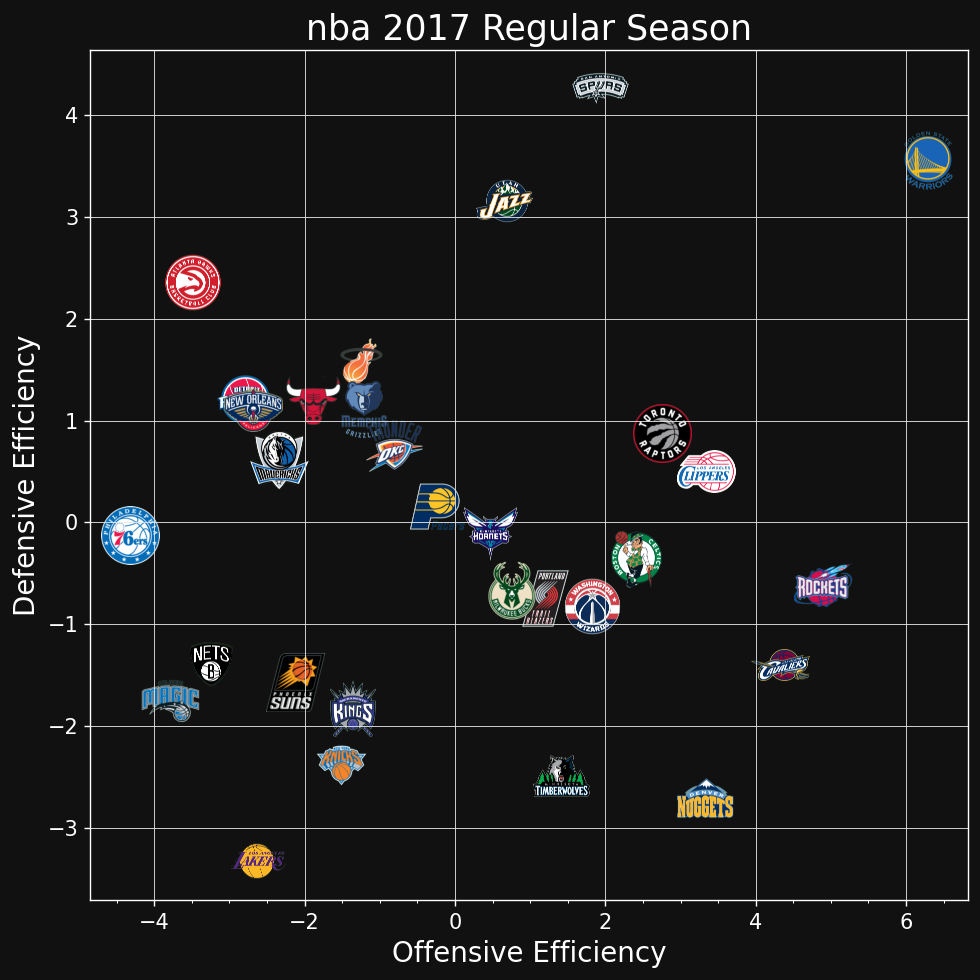

In [15]:
xs = (off_scoring_rate_est - off_scoring_rate_est.mean(1).reshape(-1, 1)).mean(0) * 100
ys = (def_scoring_rate_est.mean(1).reshape(-1, 1) - def_scoring_rate_est).mean(0) * 100
teams = [team_id_to_team_abb[inference.team_ind_to_team_id[ind]] for ind in range(xs.shape[0])]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
plot_logos(xs, ys, teams, ax, size=30)
ax.set_xlabel('Offensive Efficiency')
ax.set_ylabel('Defensive Efficiency')
ax.set_title(f'{LEAGUE} {YEAR} {SEASON_TYPE}');

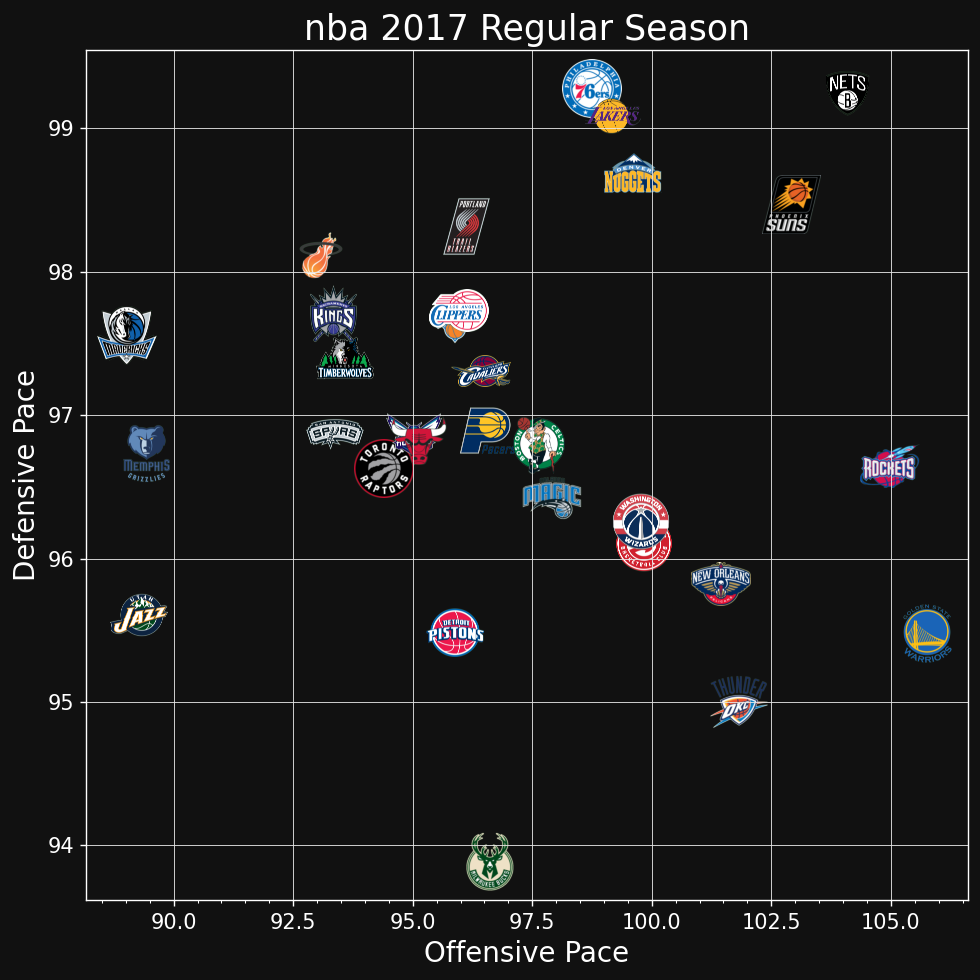

In [16]:
xs = (12 * 4 * 60 / inference.trace['off_pace'] / 2).mean(0)
ys = (12 * 4 * 60 / inference.trace['def_pace'] / 2).mean(0)
teams = [team_id_to_team_abb[inference.team_ind_to_team_id[ind]] for ind in range(xs.shape[0])]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
plot_logos(xs, ys, teams, ax, size=30)
ax.set_xlabel('Offensive Pace')
ax.set_ylabel('Defensive Pace')
ax.set_title(f'{LEAGUE} {YEAR} {SEASON_TYPE}');